In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import json
import glob
import numpy as np
import os 
import sys
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, '../../'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)
from training_data.training_data import InputData, OutputData

### 1. Training process

In [80]:
report_files = glob.glob('report_files/training_report*.json')
highest_timestamp_file = max(report_files, key=lambda x: x[-16:-5])

with open(highest_timestamp_file, 'r') as file:
    data_training = json.load(file)

print(f"Loaded data from file: {highest_timestamp_file}")

Loaded data from file: report_files/training_report_202408262115.json


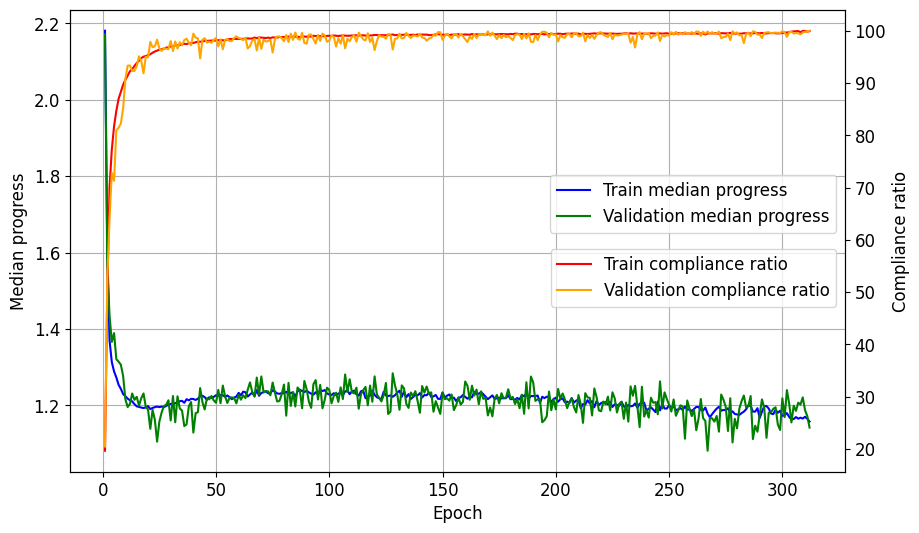

In [146]:
train_median_progress = data_training['LSTM+Dense']['train_median_progress']
train_compliance_ratios = data_training['LSTM+Dense']['train_compliance_ratios']
val_median_progress = data_training['LSTM+Dense']['val_median_progress']
val_compliance_ratios = data_training['LSTM+Dense']['val_compliance_ratios']

assert len(train_median_progress) == len(train_compliance_ratios) == len(val_median_progress) == len(val_compliance_ratios), \
    f"Arrays do not have the same length: train_median_progress={len(train_median_progress)}, " \
    f"train_compliance_ratios={len(train_compliance_ratios)}, " \
    f"val_median_progress={len(val_median_progress)}, " \
    f"val_compliance_ratios={len(val_compliance_ratios)}"

epochs = list(range(1, len(train_median_progress) + 1))

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(epochs, train_median_progress, linestyle='-', color='blue', label='Train median progress')
ax1.plot(epochs, val_median_progress, linestyle='-', color='green', label='Validation median progress')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Median progress', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(epochs, train_compliance_ratios, linestyle='-', color='red', label='Train compliance ratio')
ax2.plot(epochs, val_compliance_ratios, linestyle='-', color='orange', label='Validation compliance ratio')
ax2.set_ylabel('Compliance ratio', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax1.legend(loc='center right', bbox_to_anchor=(1, 0.58), fontsize=12)
ax2.legend(loc='center right', bbox_to_anchor=(1, 0.42), fontsize=12)

plt.show()

### 2. Cross validation

In [82]:
with open('report_files/cross_val_report.json', 'r') as file:
    data_cross_val = json.load(file)

print(f"Loaded data from file: report_files/cross_val_report.json")

Loaded data from file: report_files/cross_val_report.json


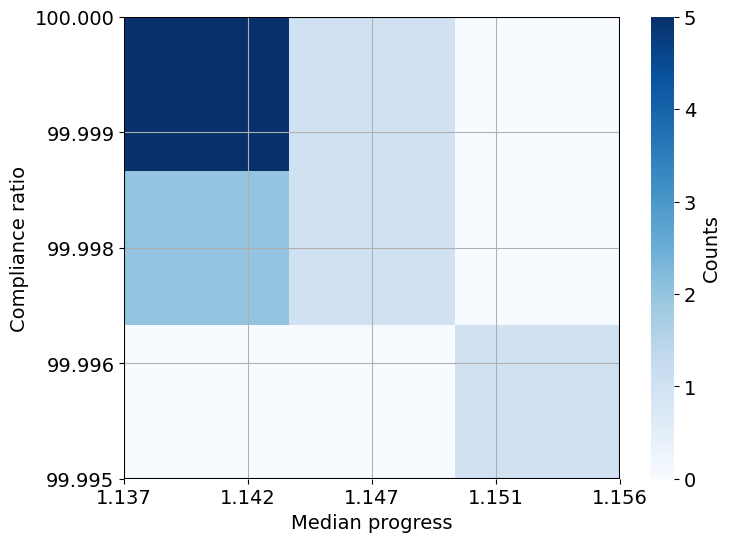

In [148]:
val_median_progress = [data['val_median_progress'] for data in data_cross_val.values()]
val_compliance_ratios = [data['val_compliance_ratios'] for data in data_cross_val.values()]

heatmap_data, xedges, yedges = np.histogram2d(val_median_progress, val_compliance_ratios, bins=3)
plt.rc('font', size=14)
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, cmap='Blues', cbar=True, xticklabels=False, yticklabels=False, cbar_kws={'label': 'Counts'})

plt.xlim(0, heatmap_data.shape[0])
plt.ylim(0, heatmap_data.shape[1])

plt.gca().set_xticks(np.linspace(0, heatmap_data.shape[0], num=5))
plt.gca().set_yticks(np.linspace(0, heatmap_data.shape[1], num=5))

plt.gca().set_xticklabels([f'{x:.3f}' for x in np.linspace(xedges[0], xedges[-1], num=5)])
plt.gca().set_yticklabels([f'{y:.3f}' for y in np.linspace(yedges[0], yedges[-1], num=5)])

plt.xlabel('Median progress', fontsize=14)
plt.ylabel('Compliance ratio', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)

plt.axhline(y=0, color='black', linewidth=1.5) 
plt.axhline(y=heatmap_data.shape[1], color='black', linewidth=1.5) 
plt.axvline(x=0, color='black', linewidth=1.5) 
plt.axvline(x=heatmap_data.shape[0], color='black', linewidth=1.5)
plt.show()

### 3. Inference on test set

In [2]:
with open('../data/min_max_values.json', 'r') as file:
    min_max_values = json.load(file)

with open('report_files/inference.json', 'r') as file:
    inference_data = json.load(file)
    actions = OutputData(np.array(inference_data['inference']))
    states = InputData(np.array(inference_data['X_test']))

def get_absolute_values(data, variable='total km'):
    """
    Extracts and returns the absolute values of the specified variable from the data for all batches,
    Input has shape [batch_size, time_steps]
    Output has shape [batch_size, time_steps]
    """
    min = min_max_values[variable]['min']
    max = min_max_values[variable]['max']
    absolute = data * (max - min) + min
    return absolute

#### 3.1 Total km actions

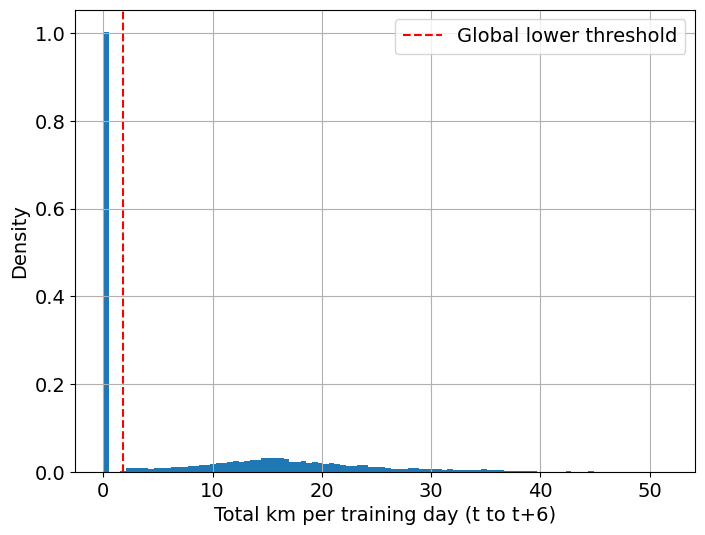

In [149]:
km_total_actions = get_absolute_values(actions['total km'], 'total km').flatten()

plt.rc('font', size=14)
plt.figure(figsize=(8, 6))
plt.hist(km_total_actions, density=True, bins=100)
plt.xlabel('Total km per training day (t to t+6)')
plt.ylabel('Density')
plt.grid(True)
plt.axvline(x=1.8, color='r', linestyle='--', linewidth=1.5, label='Global lower threshold')
plt.legend()

plt.show()

#### 3.2 Km total states

/var/folders/9g/qxrpq3xx3fzcryv3rjsw2scr0000gn/T/ipykernel_53911/3886601927.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


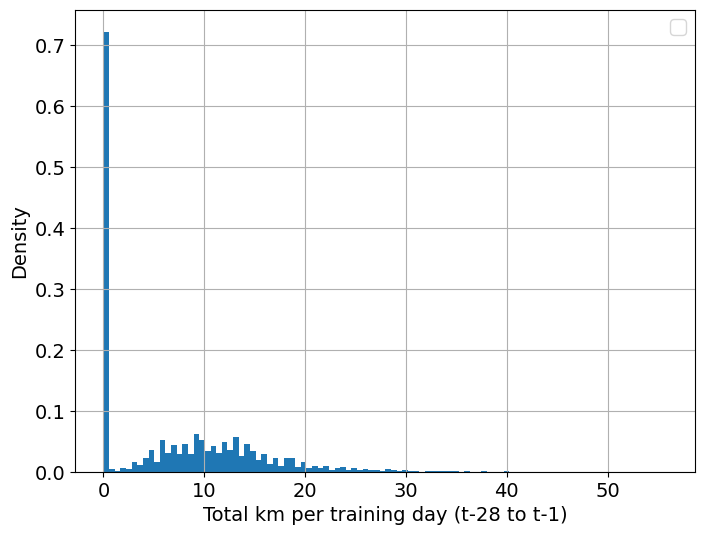

In [150]:
km_total_states = get_absolute_values(states['total km'], 'total km')[:,-28:].flatten()

plt.rc('font', size=14)
plt.figure(figsize=(8, 6))
plt.hist(km_total_states, density=True, bins=100)
plt.xlabel('Total km per training day (t-28 to t-1)')
plt.ylabel('Density')
plt.grid(True)
plt.legend()

plt.show()

#### 3.3 Km Z3-4

/var/folders/9g/qxrpq3xx3fzcryv3rjsw2scr0000gn/T/ipykernel_16576/4210306517.py:4: RuntimeWarning: invalid value encountered in divide
  ratio = km_Z34 / km_total_actions
/var/folders/9g/qxrpq3xx3fzcryv3rjsw2scr0000gn/T/ipykernel_16576/4210306517.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{x:.1f}%' for x in xticks])


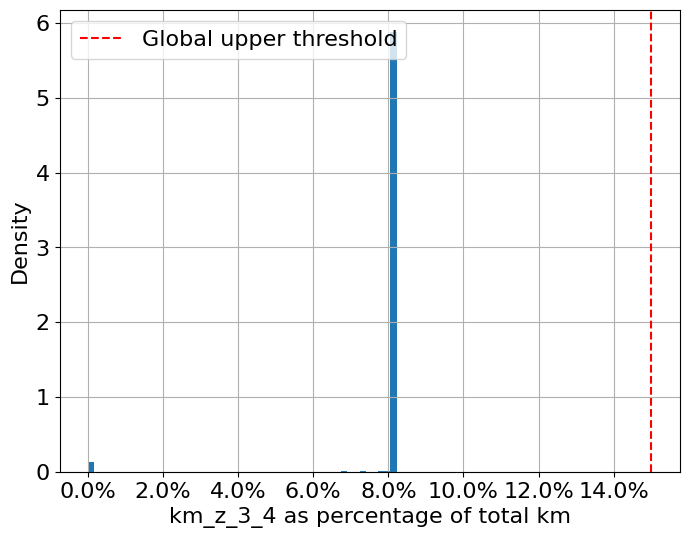

In [9]:
km_total_actions = get_absolute_values(actions['total km'], 'total km')
km_Z34 = get_absolute_values(actions['km Z3-4'], 'km Z3-4')

ratio = km_Z34 / km_total_actions
ratio = ratio.flatten()
ratio = ratio[~np.isnan(ratio)] * 100


plt.rc('font', size=16)
plt.figure(figsize=(8, 6))
plt.hist(ratio, density=True, bins=50)
plt.xlabel('km_z_3_4 as percentage of total km')
plt.ylabel('Density')
plt.axvline(x=15, color='r', linestyle='--', linewidth=1.5, label='Global upper threshold')
plt.legend()
plt.grid(True)
xticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x:.1f}%' for x in xticks])
plt.show()

#### 3.4 Km Z5

/var/folders/9g/qxrpq3xx3fzcryv3rjsw2scr0000gn/T/ipykernel_16576/4082575035.py:4: RuntimeWarning: invalid value encountered in divide
  ratio = km_Z5 / km_total_actions
/var/folders/9g/qxrpq3xx3fzcryv3rjsw2scr0000gn/T/ipykernel_16576/4082575035.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{x:.1f}%' for x in xticks])


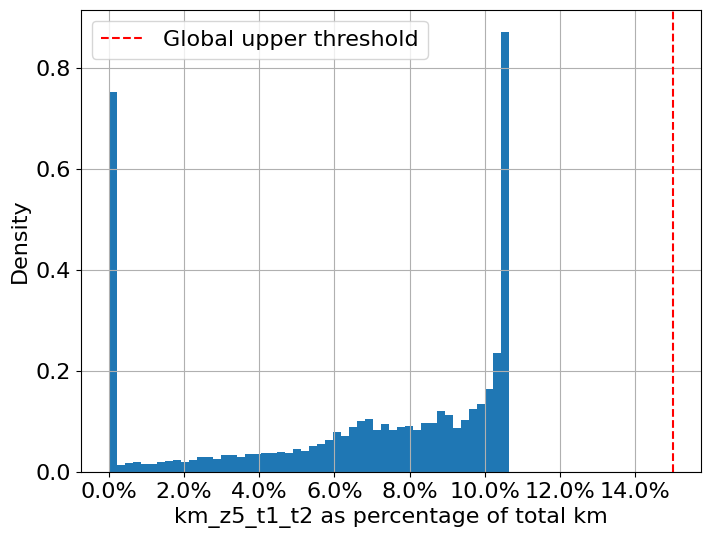

In [8]:
km_total_actions = get_absolute_values(actions['total km'], 'total km')
km_Z5 = get_absolute_values(actions['km Z5-T1-T2'], 'km Z5-T1-T2')

ratio = km_Z5 / km_total_actions

ratio = ratio.flatten()
ratio = ratio[~np.isnan(ratio)] * 100


plt.rc('font', size=16)
plt.figure(figsize=(8, 6))
plt.hist(ratio, density=True, bins=50)
plt.xlabel('km_z5_t1_t2 as percentage of total km')
plt.axvline(x=15, color='r', linestyle='--', linewidth=1.5, label='Global upper threshold')
plt.legend()
plt.ylabel('Density')
plt.grid(True)
xticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x:.1f}%' for x in xticks])
plt.show()

#### 3.5 Km Sprinting

/var/folders/9g/qxrpq3xx3fzcryv3rjsw2scr0000gn/T/ipykernel_16576/974597016.py:4: RuntimeWarning: invalid value encountered in divide
  ratio = km_sprint / km_total_actions
/var/folders/9g/qxrpq3xx3fzcryv3rjsw2scr0000gn/T/ipykernel_16576/974597016.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{x:.1f}%' for x in xticks])


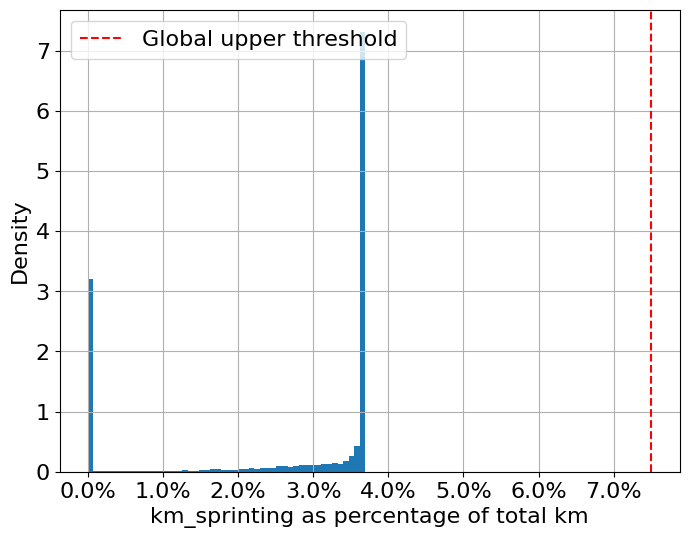

In [7]:
km_total_actions = get_absolute_values(actions['total km'], 'total km')
km_sprint = get_absolute_values(actions['km sprinting'], 'km sprinting')

ratio = km_sprint / km_total_actions

ratio = ratio.flatten()
ratio = ratio[~np.isnan(ratio)] * 100


plt.rc('font', size=16)
plt.figure(figsize=(8, 6))
plt.hist(ratio, density=True, bins=50)
plt.xlabel('km_sprinting as percentage of total km')
plt.axvline(x=7.5, color='r', linestyle='--', linewidth=1.5, label='Global upper threshold')
plt.legend()
plt.ylabel('Density')
xticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x:.1f}%' for x in xticks])
plt.grid(True)
plt.show()

#### 3.6 Progress total km

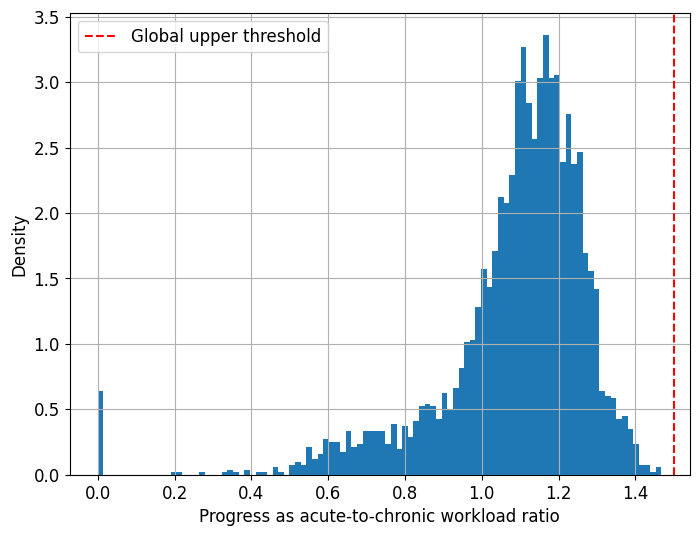

In [141]:
km_total_actions = get_absolute_values(actions['total km'], 'total km')
km_total_states = get_absolute_values(states['total km'], 'total km')[:,-28:]

km_total_actions_mean = np.mean(km_total_actions, axis=1)
km_total_states_mean = np.mean(km_total_states, axis=1) + 0.1

mask = km_total_states_mean >= 5/28

km_total_actions_mean = km_total_actions_mean[mask]
km_total_states_mean = km_total_states_mean[mask]

progress = km_total_actions_mean / km_total_states_mean

progress = progress.flatten()

plt.rc('font', size=12)
plt.figure(figsize=(8, 6))
plt.hist(progress, bins=100, density=True)
plt.xlabel('Progress as acute-to-chronic workload ratio')
plt.axvline(x=1.5, color='r', linestyle='--', linewidth=1.5, label='Global upper threshold')
plt.legend()
plt.ylabel('Density')
plt.grid(True)
plt.show()